In [ ]:
import numpy
import numpy as np
import torch
from torch import optim
from tqdm import tqdm
import random
from torch import nn
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install GPUtil
import GPUtil
from tabulate import tabulate

def gpu_info():
    gpus = GPUtil.getGPUs()
    gpus_list = []

    for gpu in gpus:
        gpu_id = gpu.id
        gpu_name = gpu.name
        gpu_load = f'{gpu.load*100}%'
        gpu_free_memory = f'{gpu.memoryFree}MB'
        gpu_used_memory = f'{gpu.memoryUsed}MB'
        gpu_total_memoru = f'{gpu.memoryTotal}MB'
        gpu_temp = f'{gpu.temperature}'

        gpus_list.append((
            gpu_id,
            gpu_name,
            gpu_load,
            gpu_free_memory,
            gpu_used_memory,
            gpu_total_memoru,
            gpu_temp
        ))
    return str(tabulate(
            gpus_list,
            headers=(
                'id',
                'name',
                'load',
                'free memory',
                'used memory',
                'total memory',
                'temperature'
            ),
            tablefmt='pretty'
        )
    )

In [ ]:
gpu_info()

'+----+-----------------------+-------+-------------+-------------+--------------+-------------+\n| id |         name          | load  | free memory | used memory | total memory | temperature |\n+----+-----------------------+-------+-------------+-------------+--------------+-------------+\n| 0  | Tesla V100S-PCIE-32GB | 0.0%  |  32495.0MB  |    4.0MB    |  32768.0MB   |    41.0     |\n| 1  | Tesla V100S-PCIE-32GB | 0.0%  |  32495.0MB  |    4.0MB    |  32768.0MB   |    39.0     |\n| 2  | Tesla V100S-PCIE-32GB | 26.0% |  30740.0MB  |  1760.0MB   |  32768.0MB   |    59.0     |\n| 3  | Tesla V100S-PCIE-32GB | 0.0%  |  32495.0MB  |    4.0MB    |  32768.0MB   |    41.0     |\n| 4  | Tesla V100S-PCIE-32GB | 0.0%  |  32495.0MB  |    4.0MB    |  32768.0MB   |    39.0     |\n| 5  | Tesla V100S-PCIE-32GB | 0.0%  |  32495.0MB  |    4.0MB    |  32768.0MB   |    37.0     |\n| 6  | Tesla V100S-PCIE-32GB | 0.0%  |  32495.0MB  |    4.0MB    |  32768.0MB   |    40.0     |\n| 7  | Tesla V100S-PCIE-32GB 

In [ ]:
def show_me_fetures(result):
    if result.dim()==4:
        for b in range(result.size()[0]):
            for f in range(result.size()[1]):
                plt.imshow(result[b,f,:,:].cpu().detach().numpy())
                plt.show()
    if result.dim()==3:
        for f in range(result.size()[0]):
            plt.imshow(result[f,:,:].cpu().detach().numpy())
            plt.show()
            
def show_me_mask(result):
    plt.figure(figsize=(12, 8))
    if result.dim()==4:
        for b in range(result.size()[0]):
            plt.imshow(torch.argmax(result[b,:,:,:], dim=0).cpu().detach().numpy())
            plt.show()
    if result.dim()==3:
        plt.imshow(torch.argmax(result, dim=0).cpu().detach().numpy())
        plt.show()
        
def train_step_segmentation(batch_size, image):
    image = image.to(device)
    Local_Features_L, global_Features = model(image)
    logit = torch.zeros(batch_size, len(global_Features), Local_Features_L.size()[2],Local_Features_L.size()[3])
    logit = logit.to(device)

    for i in range(len(global_Features)):
        r = global_Features[i][:,:,0]
        class_segmentation = torch.einsum('nchw, nc->nhw', Local_Features_L, r)
        logit[:,i,:,:]+= class_segmentation

    end_segmentation = torch.nn.functional.softmax(logit, dim = 1)
    Feature_Assignment_S = torch.zeros(Local_Features_L.size())
    Feature_Assignment_S = Feature_Assignment_S.to(device)

    for classes in range(len(global_Features)):
        Feature_Assignment_S+=torch.einsum('xyz,ij -> xjyz', end_segmentation[:, classes, :, :], global_Features[classes][:,:,0])
    return Local_Features_L, Feature_Assignment_S, end_segmentation





In [ ]:
def calculate_dot(tensor_one, tensor_two):
    tensor = tensor_one*tensor_two
    tensor_sum = torch.sum(tensor, dim = 0)
    return tensor_sum

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 12 17:17:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      4MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   

# Модель со страйдом 2

In [ ]:
class A(nn.Module):
    def __init__(self):
        super(A, self).__init__()
        self.fc1 = nn.Conv2d(kernel_size = (4,4), in_channels=1, out_channels = 64, stride=2)
        self.fc2 = nn.Conv2d(kernel_size = (4,4), in_channels=64, out_channels = 128, stride=2)
        self.fc3 = nn.BatchNorm2d(128)#пакетная нормализация???
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(self.fc3(x))
        return x

class B(nn.Module):
    def __init__(self):
        super(B, self).__init__()
        self.fc1 = nn.Conv2d(kernel_size = (4,4), in_channels=128, out_channels = 256, stride=2)
        self.bn_1 = nn.BatchNorm2d(256)
        self.flatten_1 = nn.Flatten()
        #(4x50176 and 230400x1024)
        #(4x200704 and 50176x4)
        #(4x50176 and 200704x4)
        self.fc2 = nn.Linear(50176, 4)#self.fc2 = nn.Linear(230400, 1024)#torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.bn_2 = nn.BatchNorm1d(4)#1024
        #self.flatten_2 = nn.Flatten()
        self.fc3 = nn.Linear(4, 64)#1024
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_1(x)
        x = torch.nn.functional.relu(x)
        x = self.flatten_1(x)
        x = self.fc2(x)
        x = self.bn_2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        x = torch.unsqueeze(x, 1)
        return x
    
class C(nn.Module):
    def __init__(self, P, chs):
        super(C, self).__init__()
        self.Conv_1 = nn.Conv2d(kernel_size = (1,1), in_channels=chs, out_channels = P)
        self.Conv_1_alt = nn.Conv2d(kernel_size = (1,1), in_channels=chs, out_channels = P)
        self.BatchNorm = nn.BatchNorm2d(P)
        self.Conv_2 = nn.Conv2d(kernel_size = (1,1), in_channels=P, out_channels = P)
        self.Conv_3 = nn.Conv2d(kernel_size = (1,1), in_channels=P, out_channels = P)
        
    
    def forward(self, x):
        y = self.Conv_1_alt(x)
        x = self.Conv_1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x+y) 
        return x
    
class globalC(nn.Module):
    def __init__(self, P):
        super(globalC, self).__init__()
        self.Conv_1 = nn.Conv1d(kernel_size = (1), in_channels=1, out_channels = P)
        self.Conv_1_alt = nn.Conv1d(kernel_size = (1), in_channels=1, out_channels = P)
        self.BatchNorm = nn.BatchNorm1d(P)
        self.Conv_2 = nn.Conv1d(kernel_size = (1), in_channels=P, out_channels = P)
        self.Conv_3 = nn.Conv1d(kernel_size = (1), in_channels=P, out_channels = P)
        
    
    def forward(self, x):
        y = self.Conv_1_alt(x)
        x = self.Conv_1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x+y) 
        return x

class D(nn.Module):
    def __init__(self, P):
        super(D, self).__init__()
        self.fc1 = nn.Linear(64, 1)
        self.BatchNorm = nn.BatchNorm1d(P)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        return x

class OUT(nn.Module):
    def __init__(self, num_of_classes, P):
        super(OUT, self).__init__()
        self.out = nn.ModuleList([D(P) for _ in range(num_of_classes)])
    def forward(self, x):
        result=[]
        for i in range(len(self.out)):
            result.append(self.out[i](x))
        return result
    
class InfoSeg(nn.Module):
    def __init__(self, num_of_classes, P):
        super(InfoSeg, self).__init__()
        self.A = A()
        self.B = B()
        self.C = C(P=P, chs=128)
        self.GC = globalC(P)
        self.out = OUT(num_of_classes, P)
    def forward(self, x):
        x = self.A(x)
        y = self.C(x)
        z = self.B(x)
        z = self.GC(z)
        result_global=self.out(z)
        return y, result_global

# Модель со страйдом один


In [ ]:
class A(nn.Module):
    def __init__(self):
        super(A, self).__init__()
        self.fc1 = nn.Conv2d(kernel_size = (4,4), in_channels=1, out_channels = 64, stride=1)
        self.fc2 = nn.Conv2d(kernel_size = (4,4), in_channels=64, out_channels = 128, stride=1)
        self.fc3 = nn.BatchNorm2d(128)#пакетная нормализация???
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(self.fc3(x))
        return x

class B(nn.Module):
    def __init__(self):
        super(B, self).__init__()
        self.fc1 = nn.Conv2d(kernel_size = (4,4), in_channels=128, out_channels = 256, stride=2)
        self.bn_1 = nn.BatchNorm2d(256)
        self.flatten_1 = nn.Flatten()
        #(4x50176 and 230400x1024)
        #(4x200704 and 50176x4)
        #(2x3625216 and 13660416x4)
        #для 128 на 128
        #self.fc2 = nn.Linear(921600, 4)#self.fc2 = nn.Linear(230400, 1024)#torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        #для 180 на 180 2x1893376 and 921600x4
        self.fc2 = nn.Linear(921600, 4)
        self.bn_2 = nn.BatchNorm1d(4)#1024
        #self.flatten_2 = nn.Flatten()
        self.fc3 = nn.Linear(4, 64)#1024
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_1(x)
        x = torch.nn.functional.relu(x)
        x = self.flatten_1(x)
        x = self.fc2(x)
        x = self.bn_2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        x = torch.unsqueeze(x, 1)
        return x
    
class C(nn.Module):
    def __init__(self, P, chs):
        super(C, self).__init__()
        self.Conv_1 = nn.Conv2d(kernel_size = (1,1), in_channels=chs, out_channels = P)
        self.Conv_1_alt = nn.Conv2d(kernel_size = (1,1), in_channels=chs, out_channels = P)
        self.BatchNorm = nn.BatchNorm2d(P)
        self.Conv_2 = nn.Conv2d(kernel_size = (1,1), in_channels=P, out_channels = P)
        self.Conv_3 = nn.Conv2d(kernel_size = (1,1), in_channels=P, out_channels = P)
        
    
    def forward(self, x):
        y = self.Conv_1_alt(x)
        x = self.Conv_1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x+y) 
        return x
    
class globalC(nn.Module):
    def __init__(self, P):
        super(globalC, self).__init__()
        self.Conv_1 = nn.Conv1d(kernel_size = (1), in_channels=1, out_channels = P)
        self.Conv_1_alt = nn.Conv1d(kernel_size = (1), in_channels=1, out_channels = P)
        self.BatchNorm = nn.BatchNorm1d(P)
        self.Conv_2 = nn.Conv1d(kernel_size = (1), in_channels=P, out_channels = P)
        self.Conv_3 = nn.Conv1d(kernel_size = (1), in_channels=P, out_channels = P)
        
    
    def forward(self, x):
        y = self.Conv_1_alt(x)
        x = self.Conv_1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x+y) 
        return x

class D(nn.Module):
    def __init__(self, P):
        super(D, self).__init__()
        self.fc1 = nn.Linear(64, 1)
        self.BatchNorm = nn.BatchNorm1d(P)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        return x

class OUT(nn.Module):
    def __init__(self, num_of_classes, P):
        super(OUT, self).__init__()
        self.out = nn.ModuleList([D(P) for _ in range(num_of_classes)])
    def forward(self, x):
        result=[]
        for i in range(len(self.out)):
            result.append(self.out[i](x))
        return result
    
class InfoSeg(nn.Module):
    def __init__(self, num_of_classes, P):
        super(InfoSeg, self).__init__()
        self.A = A()
        self.B = B()
        self.C = C(P=P, chs=128)
        self.GC = globalC(P)
        self.out = OUT(num_of_classes, P)
    def forward(self, x):
        x = self.A(x)
        y = self.C(x)
        z = self.B(x)
        z = self.GC(z)
        result_global=self.out(z)
        return y, result_global 

# Модель со страйдом один для изображения 180 на 180

In [ ]:
class A(nn.Module):
    def __init__(self):
        super(A, self).__init__()
        self.fc1 = nn.Conv2d(kernel_size = (4,4), in_channels=1, out_channels = 64, stride=1)
        self.fc2 = nn.Conv2d(kernel_size = (4,4), in_channels=64, out_channels = 128, stride=1)
        self.fc3 = nn.BatchNorm2d(128)#пакетная нормализация???
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(self.fc3(x))
        return x

class B(nn.Module):
    def __init__(self):
        super(B, self).__init__()
        self.fc1 = nn.Conv2d(kernel_size = (4,4), in_channels=128, out_channels = 256, stride=2)
        self.bn_1 = nn.BatchNorm2d(256)
        self.flatten_1 = nn.Flatten()
        #(4x50176 and 230400x1024)
        #(4x200704 and 50176x4)
        #(2x3625216 and 13660416x4)
        #для 128 на 128
        #self.fc2 = nn.Linear(921600, 4)#self.fc2 = nn.Linear(230400, 1024)#torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        #для 180 на 180 2x1893376 and 921600x4
        self.fc2 = nn.Linear(1893376, 4)
        self.bn_2 = nn.BatchNorm1d(4)#1024
        #self.flatten_2 = nn.Flatten()
        self.fc3 = nn.Linear(4, 64)#1024
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_1(x)
        x = torch.nn.functional.relu(x)
        x = self.flatten_1(x)
        x = self.fc2(x)
        x = self.bn_2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        x = torch.unsqueeze(x, 1)
        return x
    
class C(nn.Module):
    def __init__(self, P, chs):
        super(C, self).__init__()
        self.Conv_1 = nn.Conv2d(kernel_size = (1,1), in_channels=chs, out_channels = P)
        self.Conv_1_alt = nn.Conv2d(kernel_size = (1,1), in_channels=chs, out_channels = P)
        self.BatchNorm = nn.BatchNorm2d(P)
        self.Conv_2 = nn.Conv2d(kernel_size = (1,1), in_channels=P, out_channels = P)
        self.Conv_3 = nn.Conv2d(kernel_size = (1,1), in_channels=P, out_channels = P)
        
    
    def forward(self, x):
        y = self.Conv_1_alt(x)
        x = self.Conv_1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x+y) 
        return x
    
class globalC(nn.Module):
    def __init__(self, P):
        super(globalC, self).__init__()
        self.Conv_1 = nn.Conv1d(kernel_size = (1), in_channels=1, out_channels = P)
        self.Conv_1_alt = nn.Conv1d(kernel_size = (1), in_channels=1, out_channels = P)
        self.BatchNorm = nn.BatchNorm1d(P)
        self.Conv_2 = nn.Conv1d(kernel_size = (1), in_channels=P, out_channels = P)
        self.Conv_3 = nn.Conv1d(kernel_size = (1), in_channels=P, out_channels = P)
        
    
    def forward(self, x):
        y = self.Conv_1_alt(x)
        x = self.Conv_1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x+y) 
        return x

class D(nn.Module):
    def __init__(self, P):
        super(D, self).__init__()
        self.fc1 = nn.Linear(64, 1)
        self.BatchNorm = nn.BatchNorm1d(P)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.BatchNorm(x)
        x = torch.nn.functional.relu(x)
        return x

class OUT(nn.Module):
    def __init__(self, num_of_classes, P):
        super(OUT, self).__init__()
        self.out = nn.ModuleList([D(P) for _ in range(num_of_classes)])
    def forward(self, x):
        result=[]
        for i in range(len(self.out)):
            result.append(self.out[i](x))
        return result
    
class InfoSeg(nn.Module):
    def __init__(self, num_of_classes, P):
        super(InfoSeg, self).__init__()
        self.A = A()
        self.B = B()
        self.C = C(P=P, chs=128)
        self.GC = globalC(P)
        self.out = OUT(num_of_classes, P)
    def forward(self, x):
        x = self.A(x)
        y = self.C(x)
        z = self.B(x)
        z = self.GC(z)
        result_global=self.out(z)
        return y, result_global 

# Черновые наработки 

In [ ]:
import os

fds = sorted(os.listdir('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train'))
import pydicom as dicom
import matplotlib.pylab as plt
image_path = fds[1]
pixel_array_numpy = ds.pixel_array

ds = dicom.dcmread('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train/' + image_path)

In [ ]:
len(fds)

520811

In [ ]:
image_path = fds[1]

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt

ds = dicom.dcmread('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train/' + image_path)

In [ ]:
type(ds)

pydicom.dataset.FileDataset

In [ ]:
pixel_array_numpy = ds.pixel_array

In [ ]:
pixel_array_numpy.shape

(512, 512)

In [ ]:
image_batch = torch.zeros(4, 1, 240,240)
for b in range(4):
                #random_num = random.randint(0, 799)
                #random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
                for i in  range(180,187):
                    image = torch.tensor(np.load(img_dir + str(i)+".npz")["arr_0"])
                    #image = numpy.resize(image, (1,256,256))
                    #random_image = numpy.resize(random_image, (1,256,256))
                    image_batch[b]+=image

In [ ]:
A = Block_A()
x = A(image_batch)
print(x.shape)
B = Block_B()
z = B(x)
print(z.shape)
GC = Block_global_C(1024)
z = GC(z)
print(z.shape)
C = Block_C(1024,128)
y = C(x)
print(y.shape)
out = OUT(4,1024)
result = out(z)
print(result[0].shape)

torch.Size([4, 128, 234, 234])
torch.Size([4, 1, 64])
torch.Size([4, 1024, 64])
torch.Size([4, 1024, 234, 234])
torch.Size([4, 1024, 1])


In [ ]:
def show_me_fetures(result):
    if result.dim()==4:
        for b in range(result.size()[0]):
            for f in range(result.size()[1]):
                plt.imshow(result[b,f,:,:].cpu().detach().numpy())
                plt.show()
    if result.dim()==3:
        for f in range(result.size()[0]):
            plt.imshow(result[f,:,:].cpu().detach().numpy())
            plt.show()
            
def show_me_mask(result):
    plt.figure(figsize=(12, 8))
    if result.dim()==4:
        for b in range(result.size()[0]):
            plt.imshow(torch.argmax(result[b,:,:,:], dim=0).cpu().detach().numpy())
            plt.show()
    if result.dim()==3:
        plt.imshow(torch.argmax(result, dim=0).cpu().detach().numpy())
        plt.show()
        
def train_step_segmentation(batch_size, image):
    image = image.to(device)
    Local_Features_L, global_Features = model(image)
    logit = torch.zeros(batch_size, len(global_Features), Local_Features_L.size()[2],Local_Features_L.size()[3])
    logit = logit.to(device)

    for i in range(len(global_Features)):
        r = global_Features[i][:,:,0]
        class_segmentation = torch.einsum('nchw, nc->nhw', Local_Features_L, r)
        logit[:,i,:,:]+= class_segmentation

    end_segmentation = torch.nn.functional.softmax(logit, dim = 1)
    Feature_Assignment_S = torch.zeros(Local_Features_L.size())
    Feature_Assignment_S = Feature_Assignment_S.to(device)

    for classes in range(len(global_Features)):
        Feature_Assignment_S+=torch.einsum('xyz,ij -> xjyz', end_segmentation[:, classes, :, :], global_Features[classes][:,:,0])
    return Local_Features_L, Feature_Assignment_S, end_segmentation



def calculate_dot(tensor_one, tensor_two):
    tensor = tensor_one*tensor_two
    tensor_sum = torch.sum(tensor, dim = 0)
    return tensor_sum

In [ ]:
image = torch.tensor(np.load(img_dir + str(187)+".npz")["arr_0"])
image.shape

NameError: ignored

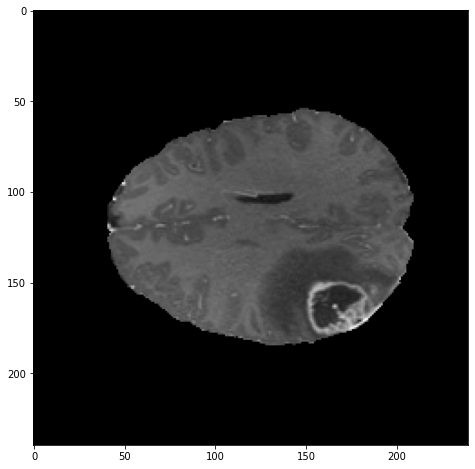

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(image[0,:,:], cmap='gray')

In [ ]:
def calculate_LS(batch_size, image):
    image = image.to(device)
    Local_Features_L, global_Features = m(image.to(device))
    logit = torch.zeros(batch_size, len(global_Features), Local_Features_L.size()[2],Local_Features_L.size()[3])
    logit = logit.to(device)

    for i in range(len(global_Features)):
        r = global_Features[i][:,:,0]
        class_segmentation = torch.einsum('nchw, nc->nhw', Local_Features_L, r)
        logit[:,i,:,:]+= class_segmentation

    end_segmentation = torch.nn.functional.softmax(logit, dim = 1)
    Feature_Assignment_S = torch.zeros(Local_Features_L.size())
    Feature_Assignment_S = Feature_Assignment_S.to(device)

    for classes in range(len(global_Features)):
        Feature_Assignment_S+=torch.einsum('xyz,ij -> xjyz', end_segmentation[:, classes, :, :], global_Features[classes][:,:,0])
    return Local_Features_L, Feature_Assignment_S, end_segmentation

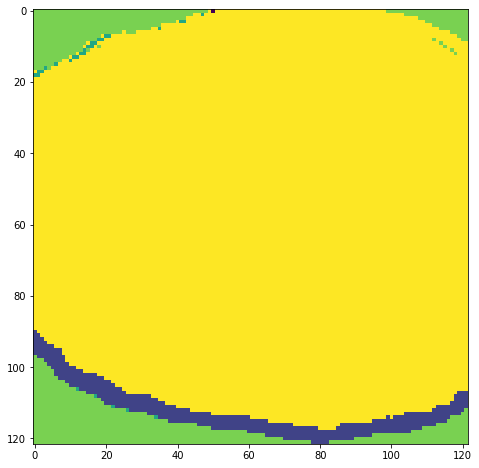

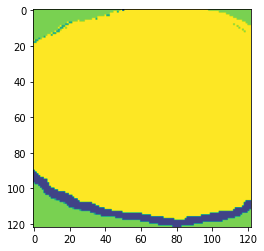

In [ ]:
segmentations = []
mod.to('cuda')
for b in range(batch_size):
                #random_num = random.randint(0, 799)
                #random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
                for i in  range(180,187):
                    image = torch.tensor(np.load(img_dir + str(i)+".npz")["arr_0"])
                    #image = numpy.resize(image, (1,256,256))
                    #random_image = numpy.resize(random_image, (1,256,256))
                    image_batch[b]+=image
mod.eval()
Local_Features_L, Feature_Assignment_S, end_segmentation=calculate_LS(batch_size, image_batch)
segmentations.append(end_segmentation)
for segmentation in segmentations:
    show_me_mask(segmentation)

In [ ]:
batch_size = 4
image_batch = torch.zeros(batch_size, 1, 128,128)
            #random_image_batch = torch.zeros(batch_size, 1, 128,128)
for b in range(batch_size):
    #random_num = random.randint(0, 799)
    #random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
    image = torch.tensor(np.load(img_dir + str(0)+".npz")["arr_0"])
    #image = numpy.resize(image, (1,256,256))
                #random_image = resize(random_image)
    image_batch[b]+=image
                #random_image_batch[b]+=random_image
image_batch.shape

torch.Size([4, 1, 128, 128])

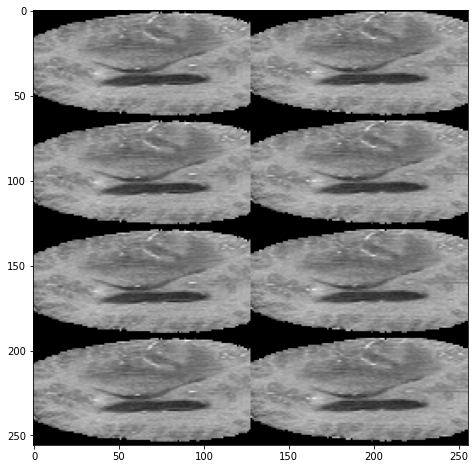

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(image_batch[0,0,:,:], cmap='gray')

In [ ]:
image_batch
class_a = Block_A().to('cuda')
x = class_a(image_batch.to('cuda'))
print(x.shape)
class_c = Block_C(P = 1024, chs = 1).to('cuda')
y = class_c(image_batch.to('cuda'))
print(y.shape)

torch.Size([4, 128, 30, 30])
torch.Size([4, 1024, 128, 128])


In [ ]:
class_b = Block_B().to('cuda')
z = class_b(x)
z.shape

torch.Size([4, 1, 64])

In [ ]:
GC = Block_global_C(P = 1024).to('cuda')
z = GC(z)
z.shape

torch.Size([4, 1024, 64])

In [ ]:
out = OUT(num_of_classes = 4, P = 1024).to('cuda')
result = out(z)

In [ ]:
result

AttributeError: ignored

# Обучение

In [ ]:
device = ("cuda:0")
P = 1024
num_of_classes = 6
model = InfoSeg(num_of_classes = num_of_classes, P = P)
model.to(device)
Softplus = torch.nn.Softplus(threshold = 20)
batch_size = 4

optimizer = optim.Adam(params = model.parameters(), lr=0.0001)


In [ ]:
img_dir = '/content/drive/MyDrive/BratS_numpy_dataset_2/'
img_dir_180_on_180 = '/content/drive/MyDrive/BratS_numpy_dataset_3_180*180/'

# Обучение для изображений 180 на 180

In [ ]:
model = InfoSeg(num_of_classes = num_of_classes, P = P)
model.to('cuda')
optimizer = optim.Adam(params = model.parameters(), lr=0.0001)

checkpoint = torch.load('/content/drive/MyDrive/InfoSeg_23_epoch_0_601')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

InfoSeg(
  (A): A(
    (fc1): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
    (fc2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (fc3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (B): B(
    (fc1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (bn_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten_1): Flatten(start_dim=1, end_dim=-1)
    (fc2): Linear(in_features=1893376, out_features=4, bias=True)
    (bn_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=4, out_features=64, bias=True)
  )
  (C): C(
    (Conv_1): Conv2d(128, 1024, kernel_size=(1, 1), stride=(1, 1))
    (Conv_1_alt): Conv2d(128, 1024, kernel_size=(1, 1), stride=(1, 1))
    (BatchNorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv_2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    (Conv_

In [ ]:
import os
import pydicom as dicom
import matplotlib.pylab as plt
fds = sorted(os.listdir('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train'))

#image_path = fds[1]
#pixel_array_numpy = ds.pixel_array

#ds = dicom.dcmread('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train/' + image_path)

In [ ]:
len(fds)

520811

In [ ]:
fds.remove(fds[359975])

In [ ]:
import cv2

In [ ]:
cvuint8 = cv2.convertScaleAbs(random_image)

In [ ]:
random_image = dicom.dcmread('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train/' + fds[175479]).pixel_array

In [ ]:
cvuint8 = torch.tensor(cvuint8)

In [ ]:
type(cvuint8)

torch.Tensor

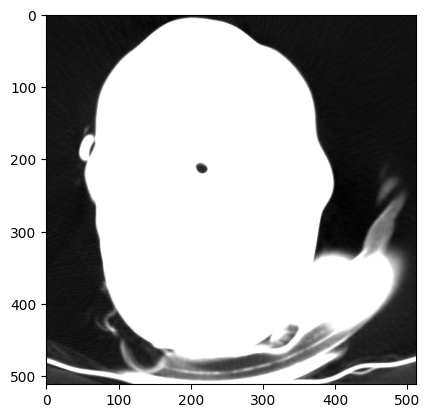

In [ ]:
plt.imshow(cvuint8, cmap = 'gray')
plt.show()

In [ ]:
epochs = 100
n_image = 520800
epoch_loss = 0
#m.to('cuda')
for epoch in range(epochs):
    model.train()
    idx=0
    segmentations = []
    with tqdm(total=n_image, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        while idx<n_image:
            
            optimizer.zero_grad()
            
            image_batch = torch.zeros(batch_size, 1, 512,512)
            random_image_batch = torch.zeros(batch_size, 1, 512,512)

            for b in range(batch_size):
                random_num = random.randint(0, 520800)
                print(random_num)
                random_image = torch.tensor(cv2.convertScaleAbs(dicom.dcmread('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train/' + fds[random_num]).pixel_array))
                image = torch.tensor(cv2.convertScaleAbs(dicom.dcmread('/home/ailab_user/SCT/Datasets/rsna-intracranial-hemorrhage-detection/stage_2_train/' + fds[idx]).pixel_array))
                
                #image = numpy.resize(image, (1,256,256))
                #random_image = numpy.resize(random_image, (1,256,256))
                image_batch[b]+=image
                random_image_batch[b]+=random_image
                idx+=1

            Local_Features_L, Feature_Assignment_S, end_segmentation=train_step_segmentation(batch_size, image_batch)
            random_Local_Features_L, random_Feature_Assignment_S, random_end_segmentation=train_step_segmentation(batch_size, random_image_batch)
            if idx%100000==0:
                segmentations.append(random_end_segmentation)
            sp = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)
            sp_r = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], Feature_Assignment_S[examle_num])*-1
                sp+=Softplus(dot)*-1

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], random_Feature_Assignment_S[examle_num])
                sp_r+=Softplus(dot)

            sp = sp/batch_size
            sp_r/batch_size

            loss = torch.mean(sp-sp_r)*-1
            epoch_loss+=loss.item()
            epoch_loss/=idx
            loss.backward(retain_graph=True)
            optimizer.step()
            
            pbar.set_postfix(**{'loss(mean)':epoch_loss})
            pbar.update(batch_size)
#     model.eval()
    
    for segmentation in segmentations:
        show_me_mask(segmentation)

Epoch 1/100:   0%|          | 0/520800 [00:00<?, ?img/s]


423169
431962
37208
40939


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x16257024 and 1893376x4)

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/InfoSeg_23_epoch_0_601')

In [ ]:
batch_size = 1
image_batch = torch.zeros(batch_size, 1, 180,180)
idx = 19
segmentations = []
for b in range(batch_size):
                image = torch.tensor(np.load('/content/drive/MyDrive/BratS_numpy_dataset_3_180*180_test/'  + str(idx)+".npz")["arr_0"])
                
                    #image = numpy.resize(image, (1,256,256))
                    #random_image = numpy.resize(random_image, (1,256,256))
                image_batch[b]+=image
                idx+=1
model.eval()
Local_Features_L, Feature_Assignment_S, end_segmentation=train_step_segmentation(batch_size, image_batch)
segmentations.append(end_segmentation)

In [ ]:
img_targ = torch.tensor(np.load('/content/drive/MyDrive/BratS_numpy_dataset_target_3_180*180/' + str(1500)+".npz")["arr_0"])

In [ ]:
image = torch.tensor(np.load(img_dir_180_on_180  + str(idx)+".npz")["arr_0"])

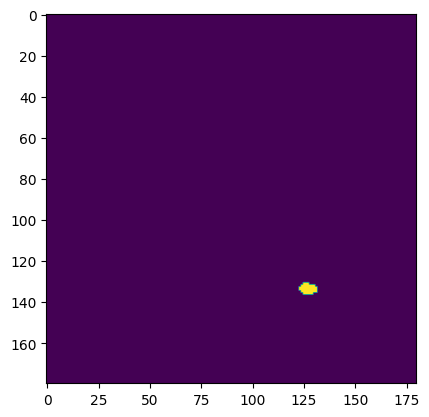

In [ ]:
plt.imshow(img_targ[0,:,:])


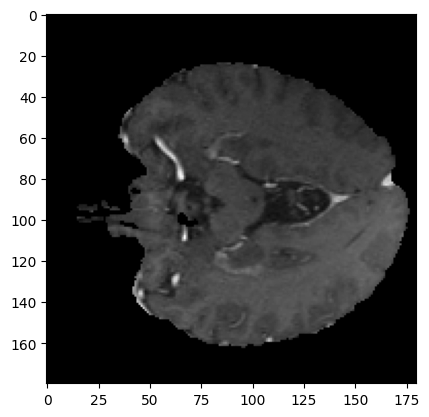

In [ ]:
plt.imshow(image_batch[1,0,:,:], cmap='gray')

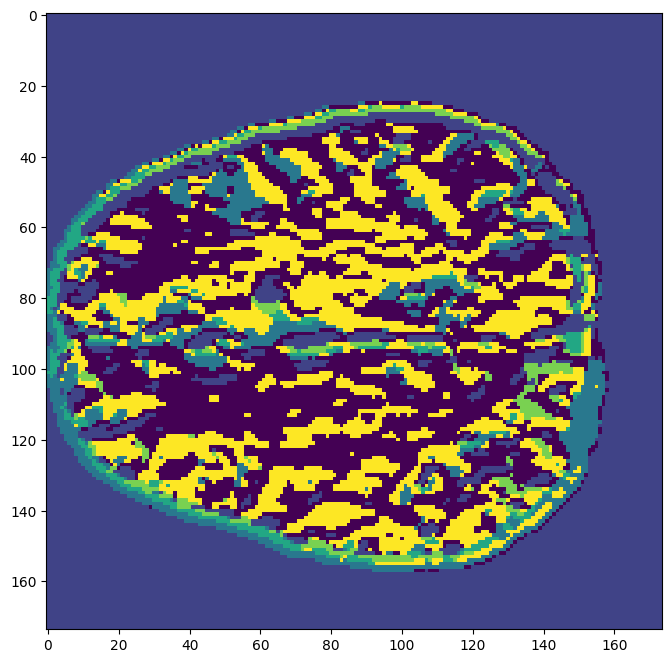

In [ ]:
for segmentat in segmentations:
        show_me_mask(segmentat)

In [ ]:
array = []

In [ ]:
for segmentation in segmentations:
    array.append(segmentation)

In [ ]:
segmentat[0].shape

torch.Size([6, 174, 174])

In [ ]:
len(array)

20

In [ ]:
import torchvision
for idx in range(20):
    img = torch.argmax(array[idx][0], dim=0).cpu().detach().numpy()
    img = torch.as_tensor(img, dtype = torch.float64)
    torchvision.utils.save_image(img, '/content/drive/MyDrive/Info_seg_out_20/'+ str(idx) + '.JPG')

# Продолжение тренировки модели со страйдом 1 и 40-ка эпохами

In [ ]:
batch_size = 2

In [ ]:
epochs = 100
n_image = 520800
epoch_loss = 0
#m.to('cuda')
for epoch in range(epochs):
    model.train()
    idx=0
    segmentations = []
    with tqdm(total=n_image, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        while idx<n_image:
            
            optimizer.zero_grad()
            
            image_batch = torch.zeros(batch_size, 1, 128,128)
            random_image_batch = torch.zeros(batch_size, 1, 128,128)

            for b in range(batch_size):
                random_num = random.randint(0, 799)
                random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
                image = torch.tensor(np.load(img_dir + str(idx)+".npz")["arr_0"])
                
                #image = numpy.resize(image, (1,256,256))
                #random_image = numpy.resize(random_image, (1,256,256))
                image_batch[b]+=image
                random_image_batch[b]+=random_image
                idx+=1

            Local_Features_L, Feature_Assignment_S, end_segmentation=train_step_segmentation(batch_size, image_batch)
            random_Local_Features_L, random_Feature_Assignment_S, random_end_segmentation=train_step_segmentation(batch_size, random_image_batch)
            if idx%100==0:
                segmentations.append(random_end_segmentation)
            sp = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)
            sp_r = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], Feature_Assignment_S[examle_num])*-1
                sp+=Softplus(dot)*-1

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], random_Feature_Assignment_S[examle_num])
                sp_r+=Softplus(dot)

            sp = sp/batch_size
            sp_r/batch_size

            loss = torch.mean(sp-sp_r)*-1
            epoch_loss+=loss.item()
            epoch_loss/=idx
            loss.backward(retain_graph=True)
            optimizer.step()
            
            pbar.set_postfix(**{'loss(mean)':epoch_loss})
            pbar.update(batch_size)
#     model.eval()
    
    for segmentation in segmentations:
        show_me_mask(segmentation)
        segmentation.shape

In [ ]:
batch_size = 2
image_batch = torch.zeros(batch_size, 1, 128,128)
n = 50
idx = 84
segmentations = []
for b in range(batch_size):
                image = torch.tensor(np.load(img_dir + str(idx)+".npz")["arr_0"])
                
                    #image = numpy.resize(image, (1,256,256))
                    #random_image = numpy.resize(random_image, (1,256,256))
                image_batch[b]+=image
                idx+=1
model.eval()
Local_Features_L, Feature_Assignment_S, end_segmentation=train_step_segmentation(batch_size, image_batch)
segmentations.append(end_segmentation)   
    

In [ ]:
for segmentation in segmentations:
        show_me_mask(segmentation)

In [ ]:

img = torch.argmax(segmentation[0], dim=0).cpu().detach().numpy()
img = torch.as_tensor(img, dtype = torch.float64)
import torchvision
torchvision.utils.save_image(img, '/content/drive/MyDrive/1.JPG')

# Новый раздел

In [ ]:
epochs = 100
n_image = 800
epoch_loss = 0
#m.to('cuda')
for epoch in range(epochs):
    model.train()
    idx=0
    segmentations = []
    with tqdm(total=n_image, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        while idx<n_image:
            
            optimizer.zero_grad()
            
            image_batch = torch.zeros(batch_size, 1, 128,128)
            random_image_batch = torch.zeros(batch_size, 1, 128,128)

            for b in range(batch_size):
                random_num = random.randint(0, 799)
                random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
                image = torch.tensor(np.load(img_dir + str(idx)+".npz")["arr_0"])
                
                #image = numpy.resize(image, (1,256,256))
                #random_image = numpy.resize(random_image, (1,256,256))
                image_batch[b]+=image
                random_image_batch[b]+=random_image
                idx+=1

            Local_Features_L, Feature_Assignment_S, end_segmentation=calculate_LS(batch_size, image_batch)
            random_Local_Features_L, random_Feature_Assignment_S, random_end_segmentation=calculate_LS(batch_size, random_image_batch)
            if idx%100==0:
                segmentations.append(random_end_segmentation)
            sp = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)
            sp_r = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], Feature_Assignment_S[examle_num])*-1
                sp+=Softplus(dot)*-1

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], random_Feature_Assignment_S[examle_num])
                sp_r+=Softplus(dot)

            sp = sp/batch_size
            sp_r/batch_size

            loss = torch.mean(sp-sp_r)*-1
            epoch_loss+=loss.item()
            epoch_loss/=idx
            loss.backward(retain_graph=True)
            optimizer.step()
            
            pbar.set_postfix(**{'loss(mean)':epoch_loss})
            pbar.update(batch_size)
#     model.eval()
    
    for segmentation in segmentations:
        show_me_mask(segmentation)

In [ ]:
epochs = 100
n_image = 800
epoch_loss = 0
for epoch in range(epochs):
    model.train()
    idx=0
    segmentations = []
    with tqdm(total=n_image, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        while idx<n_image:
            
            optimizer.zero_grad()
            
            image_batch = torch.zeros(batch_size, 1, 128,128)
            random_image_batch = torch.zeros(batch_size, 1, 128,128)

            for b in range(batch_size):
                random_num = random.randint(0, 799)
                random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
                image = torch.tensor(np.load(img_dir + str(idx)+".npz")["arr_0"])
                
                #image = numpy.resize(image, (1,256,256))
                #random_image = numpy.resize(random_image, (1,256,256))
                image_batch[b]+=image
                random_image_batch[b]+=random_image
                idx+=1

            Local_Features_L, Feature_Assignment_S, end_segmentation=calculate_LS(batch_size, image_batch)
            random_Local_Features_L, random_Feature_Assignment_S, random_end_segmentation=calculate_LS(batch_size, random_image_batch)
            if idx%100==0:
                segmentations.append(random_end_segmentation)
            sp = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)
            sp_r = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], Feature_Assignment_S[examle_num])*-1
                sp+=Softplus(dot)*-1

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], random_Feature_Assignment_S[examle_num])
                sp_r+=Softplus(dot)

            sp = sp/batch_size
            sp_r/batch_size

            loss = torch.mean(sp-sp_r)*-1
            epoch_loss+=loss.item()
            epoch_loss/=idx
            loss.backward(retain_graph=True)
            optimizer.step()
            
            pbar.set_postfix(**{'loss(mean)':epoch_loss})
            pbar.update(batch_size)
#     model.eval()
    
    for segmentation in segmentations:
        show_me_mask(segmentation)

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/InfoSeg_4_epoch')

In [ ]:
model = InfoSeg(num_of_classes = num_of_classes, P = P)
model.to('cuda')
optimizer = optim.Adam(params = model.parameters(), lr=0.0001)

checkpoint = torch.load('/content/drive/MyDrive/InfoSeg_41_epoch')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

InfoSeg(
  (A): A(
    (fc1): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
    (fc2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (fc3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (B): B(
    (fc1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (bn_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten_1): Flatten(start_dim=1, end_dim=-1)
    (fc2): Linear(in_features=921600, out_features=4, bias=True)
    (bn_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=4, out_features=64, bias=True)
  )
  (C): C(
    (Conv_1): Conv2d(128, 1024, kernel_size=(1, 1), stride=(1, 1))
    (Conv_1_alt): Conv2d(128, 1024, kernel_size=(1, 1), stride=(1, 1))
    (BatchNorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv_2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    (Conv_3

In [ ]:

epochs = 100
n_image = 2000
epoch_loss = 0
for epoch in range(epochs):
    net.train()
    idx=0
    segmentations = []
    with tqdm(total=n_image, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        while idx<n_image:
            
            optimizer.zero_grad()
            
            image_batch = torch.zeros(batch_size, 1, 240,240)
            random_image_batch = torch.zeros(batch_size, 1, 240,240)
            random_arr = []
            random_arr_seg = []
            for b in range(batch_size):
                random_num = random.randint(0, 1999)
                random_image = torch.tensor(np.load(img_dir + str(random_num)+".npz")["arr_0"])
                image = torch.tensor(np.load(img_dir + str(idx)+".npz")["arr_0"])
                #image = numpy.resize(image, (1,256,256))
                #random_image = numpy.resize(random_image, (1,256,256))
                #plt.figure(figsize=(12, 8))
                #plt.imshow(random_image[0,:,:], cmap='gray')
                image_batch[b]+=image
                random_image_batch[b]+=random_image
                random_arr.append(random_num)
                idx+=1

            Local_Features_L, Feature_Assignment_S, end_segmentation=calculate_LS(batch_size, image_batch)
            random_Local_Features_L, random_Feature_Assignment_S, random_end_segmentation=calculate_LS(batch_size, random_image_batch)
            if idx%100==0:
                segmentations.append(random_end_segmentation)
                random_arr_seg.append(random_arr)
            sp = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)
            sp_r = torch.zeros(Local_Features_L[0].size()[1], Local_Features_L[0].size()[2]).to(device)

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], Feature_Assignment_S[examle_num])*-1
                sp+=Softplus(dot)*-1

            for examle_num in range(batch_size):
                dot = calculate_dot(Local_Features_L[examle_num], random_Feature_Assignment_S[examle_num])
                sp_r+=Softplus(dot)

            sp = sp/batch_size
            sp_r/batch_size

            loss = torch.mean(sp-sp_r)*-1
            epoch_loss+=loss.item()
            epoch_loss/=idx
            loss.backward(retain_graph=True)
            optimizer.step()
            
            pbar.set_postfix(**{'loss(mean)':epoch_loss})
            pbar.update(batch_size)
#     net.eval()
    
    for segmentation in segmentations:
        show_me_mask(segmentation)


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?img/s]


OutOfMemoryError: ignored

# Выделение выпуклых областей

In [ ]:
import cv2
import torch
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image

0


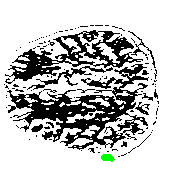

1


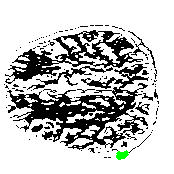

2


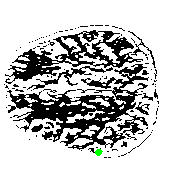

3


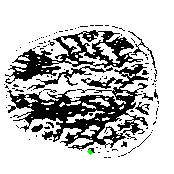

4


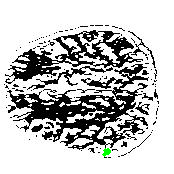

5


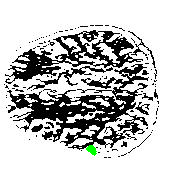

6


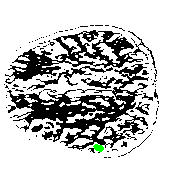

7


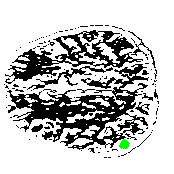

8


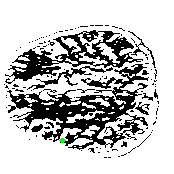

9


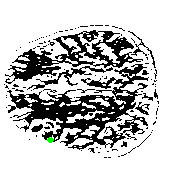

10


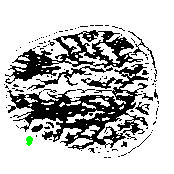

11


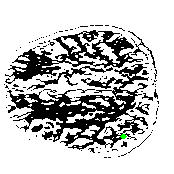

12


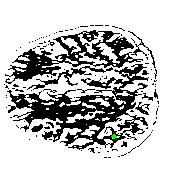

13


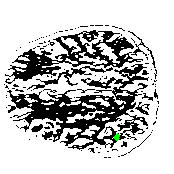

14


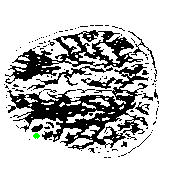

15


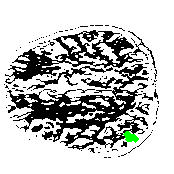

16


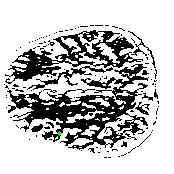

17


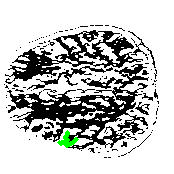

18


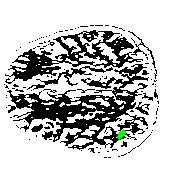

19


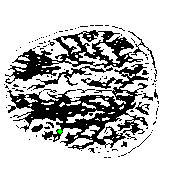

20


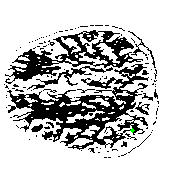

21


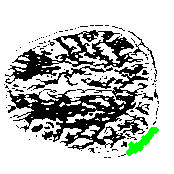

22


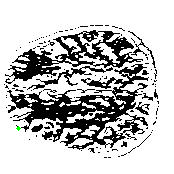

23


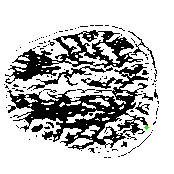

24


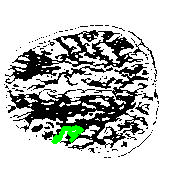

25


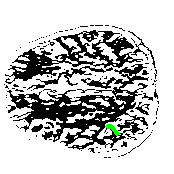

26


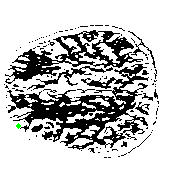

27


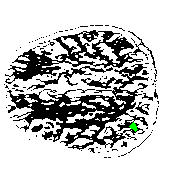

28


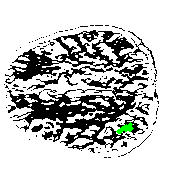

29


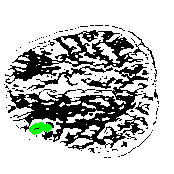

30


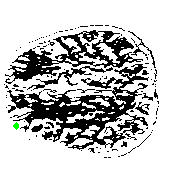

31


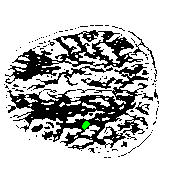

32


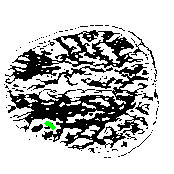

33


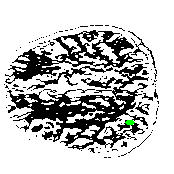

34


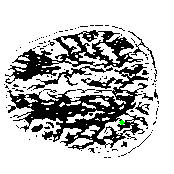

35


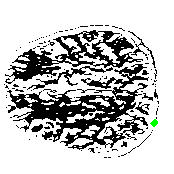

36


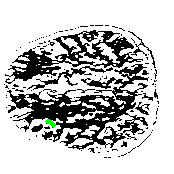

37


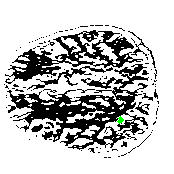

38


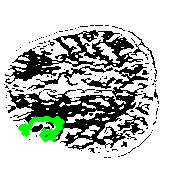

39


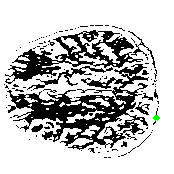

40


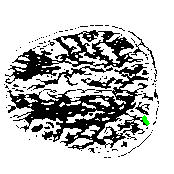

41


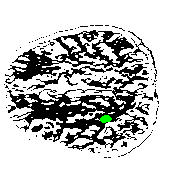

42


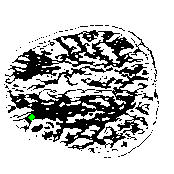

43


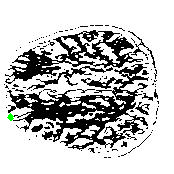

44


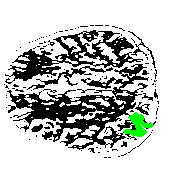

45


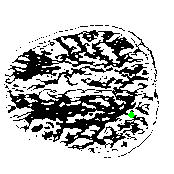

46


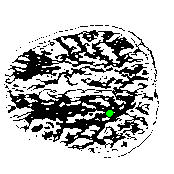

47


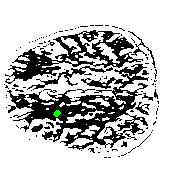

48


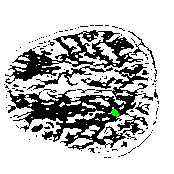

49


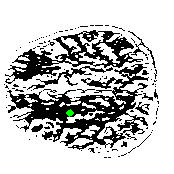

50


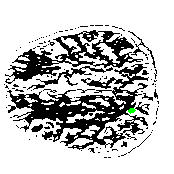

51


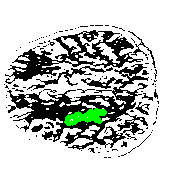

52


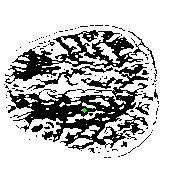

53


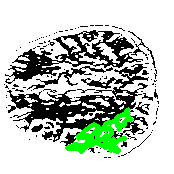

54


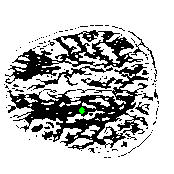

55


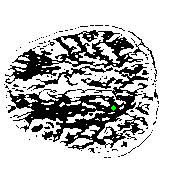

56


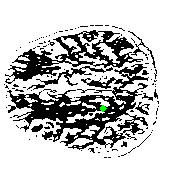

57


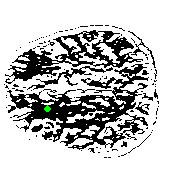

58


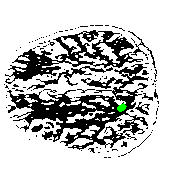

59


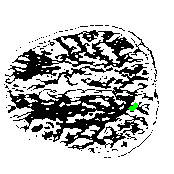

60


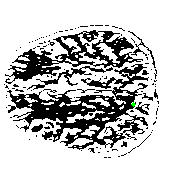

61


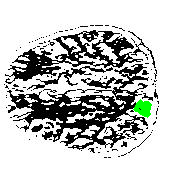

62


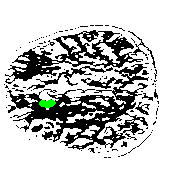

63


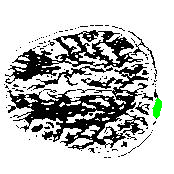

64


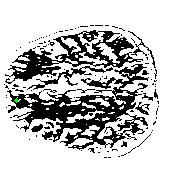

65


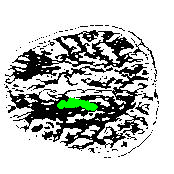

66


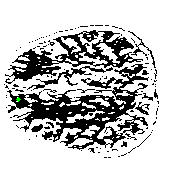

67


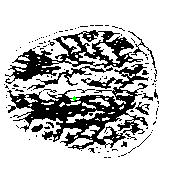

68


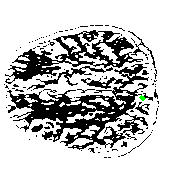

69


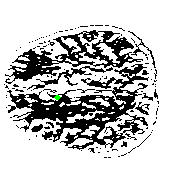

70


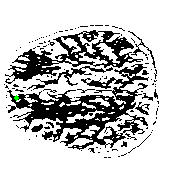

71


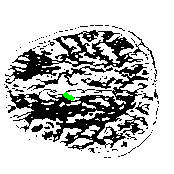

72


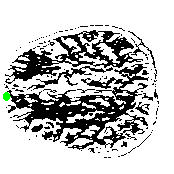

73


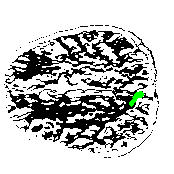

74


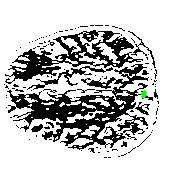

75


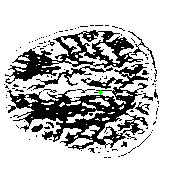

76


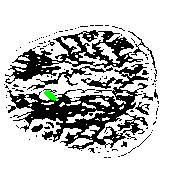

77


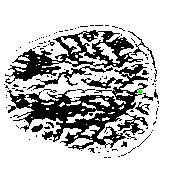

78


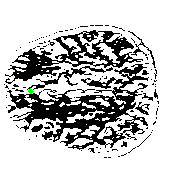

79


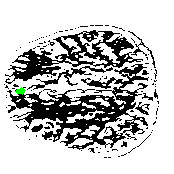

80


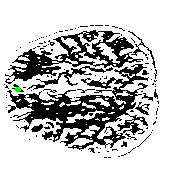

81


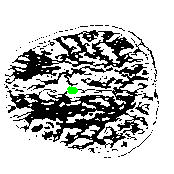

82


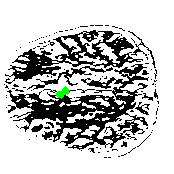

83


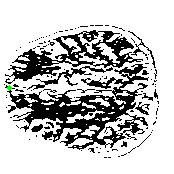

84


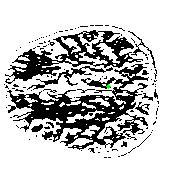

85


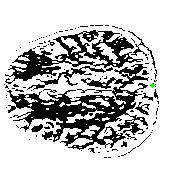

86


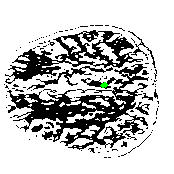

87


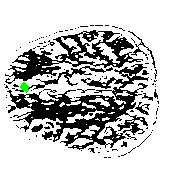

88


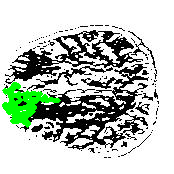

89


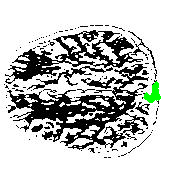

90


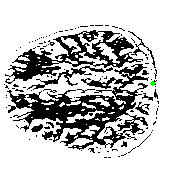

91


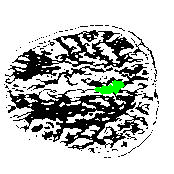

92


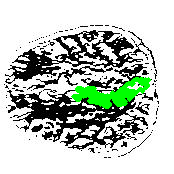

93


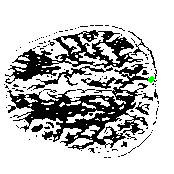

94


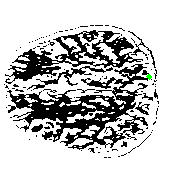

95


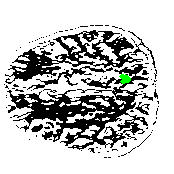

96


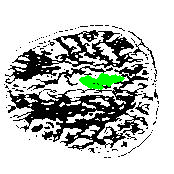

97


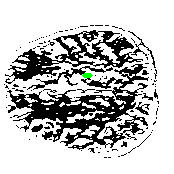

98


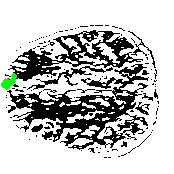

99


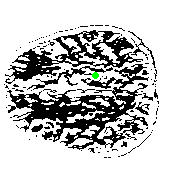

100


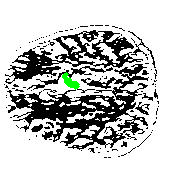

101


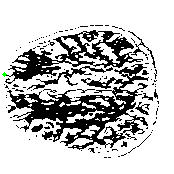

102


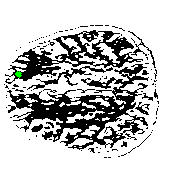

103


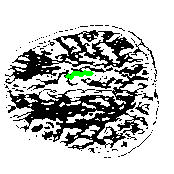

104


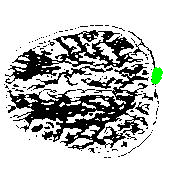

105


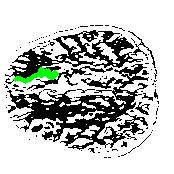

106


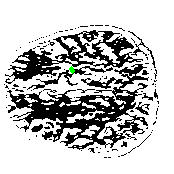

107


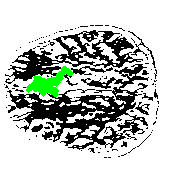

108


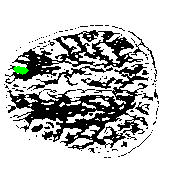

109


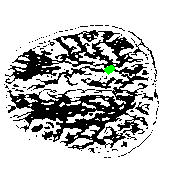

110


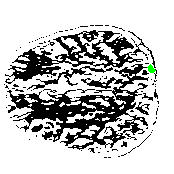

111


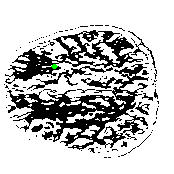

112


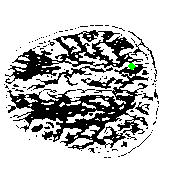

113


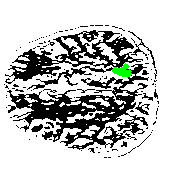

114


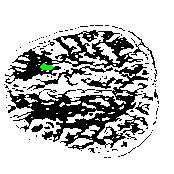

115


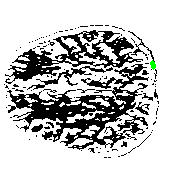

116


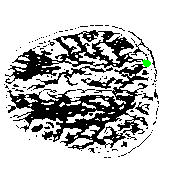

117


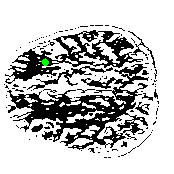

118


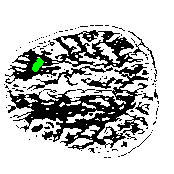

119


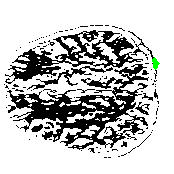

120


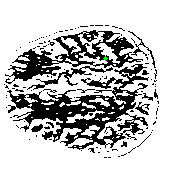

121


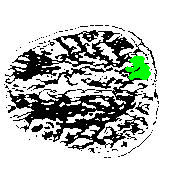

122


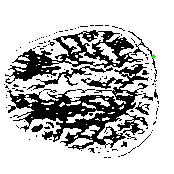

123


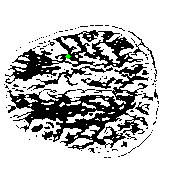

124


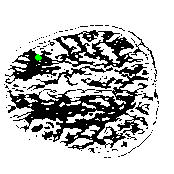

125


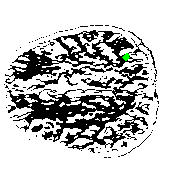

126


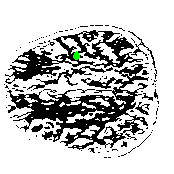

127


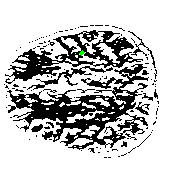

128


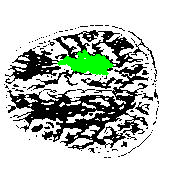

129


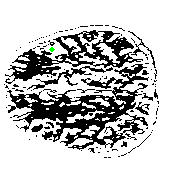

130


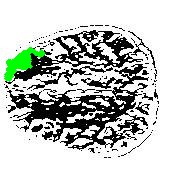

131


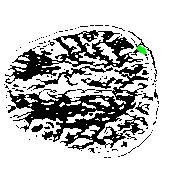

132


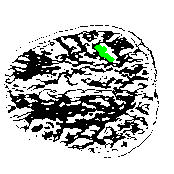

133


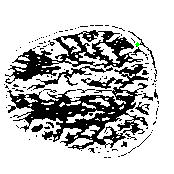

134


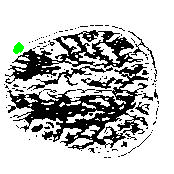

135


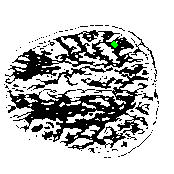

136


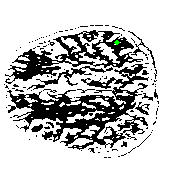

137


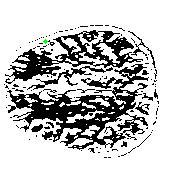

138


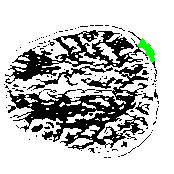

139


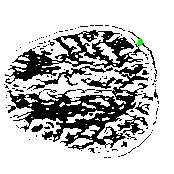

140


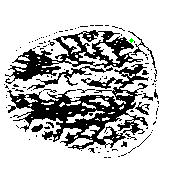

141


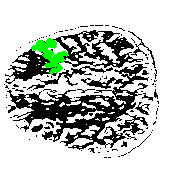

142


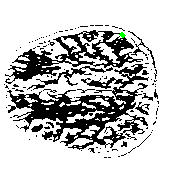

143


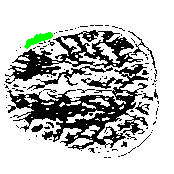

144


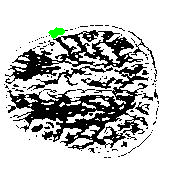

145


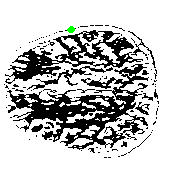

146


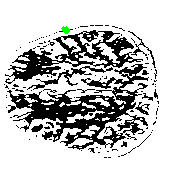

147


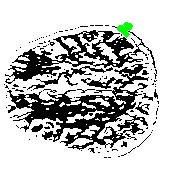

148


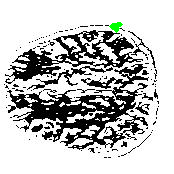

149


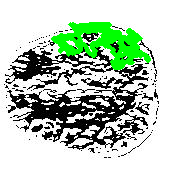

In [ ]:
for i in range(150):
    print(i)
    img = cv2.imread('/content/drive/MyDrive/Info_seg_out_20/19.JPG')
#cv2_imshow(img)
    cv2.waitKey(0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Find Canny edges
    edged = cv2.Canny(gray, 30, 200)
    cv2.waitKey(0)
  
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
    contours, hierarchy = cv2.findContours(edged, 
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
#cv2_imshow( edged)
    cv2.waitKey(0)
    cv2.drawContours(img, contours, i, (0, 255, 0), 3)
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Number of Contours found = 150


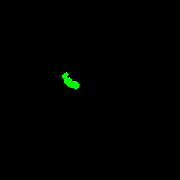

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Info_seg_out_20/19.JPG')
#cv2_imshow(img)
cv2.waitKey(0)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Find Canny edges
edged = cv2.Canny(gray, 30, 200)
cv2.waitKey(0)
  
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
#cv2_imshow( edged)
cv2.waitKey(0)
  
print("Number of Contours found = " + str(len(contours)))
  
# Draw all contours
# -1 signifies drawing all contours
zero_img = np.zeros((180,180,3))
cv2.drawContours(zero_img, contours, 100, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 104, (0, 255, 0), 3) 
#cv2.drawContours(zero_img, contours, 100, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 98, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 95, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 94, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 93, (0, 255, 0), 3)

#cv2.drawContours(zero_img, contours, 92, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 89, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 87, (0, 255, 0), 3)
#cv2.drawContours(zero_img, contours, 83, (0, 255, 0), 3)





cv2_imshow(zero_img)
#cv2.imwrite('/content/drive/MyDrive/1_contours.JPG', zero_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
array_img = []

In [ ]:
array_img.append(zero_img[:,:])

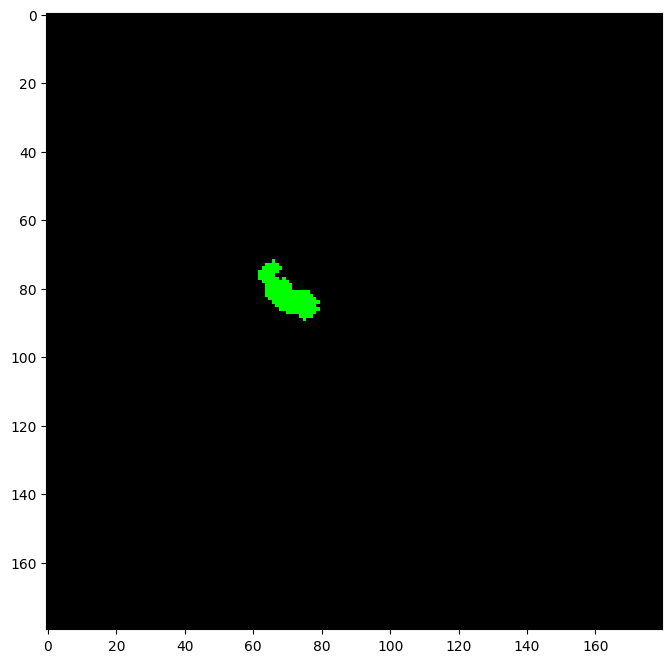

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(zero_img[:,:], cmap='gray')

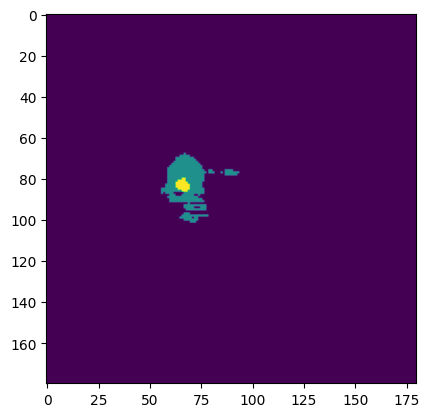

In [ ]:
img_targ = torch.tensor(np.load('/content/drive/MyDrive/BratS_numpy_dataset_target_180*180_test/' + str(19)+".npz")["arr_0"])
plt.imshow(img_targ[0,:,:])

In [ ]:
cv2.imwrite('/content/drive/MyDrive/contours_20/'+ str(19)+ '.JPG', array_img[0]) 

NameError: ignored

In [ ]:
contours[21].shape

(49, 1, 2)